In [1]:
import keras
from keras.models import Model
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from keras.applications.vgg19 import preprocess_input
%matplotlib inline

Using TensorFlow backend.


In [43]:
from keras.applications.vgg16 import VGG16
base_model = VGG16(weights='imagenet')
# 获取各层的输出：
layer_outputs = [layer.output for layer in base_model.layers[1:20]]
# 获取各层的名称：
layer_names = []
for layer in base_model.layers[1:20]:
    layer_names.append(layer.name)
print(layer_names)

553467904/553467096 [==============================] - 15s 0us/step
['block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool', 'flatten']


In [44]:
# 组装模型：
model = Model(inputs=base_model.input, outputs=layer_outputs)
# 将前面的图片数据x，输入到model中，得到各层的激活值activations：
# activations = model.predict(x)
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

(1, 224, 224, 3)

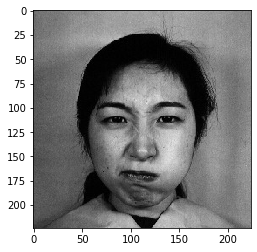

In [45]:
img_path = '../../jaffe/ANGRY/angry1.jpg'
img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
x.shape

In [46]:
from keras import models
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model.layers[:20]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [47]:
# This will return a list of 5 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(x)

In [48]:
first_layer_activation = activations[13]
print(first_layer_activation.shape)

(1, 28, 28, 512)


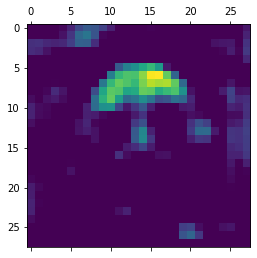

In [49]:
import matplotlib.pyplot as plt

plt.matshow(first_layer_activation[0, :, :, 10], cmap='viridis')
plt.show()

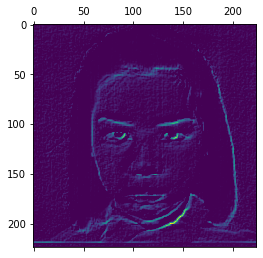

In [10]:
plt.matshow(first_layer_activation[0, :, :, 30], cmap='viridis')
plt.show()

### 可视化卷积核

In [1]:
from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet',
              include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

Using TensorFlow backend.


In [2]:
# The call to `gradients` returns a list of tensors (of size 1 in this case)
# hence we only keep the first element -- which is a tensor.
grads = K.gradients(loss, model.input)[0]

In [3]:
# We add 1e-5 before dividing so as to avoid accidentally dividing by 0.
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

In [4]:
iterate = K.function([model.input], [loss, grads])

# Let's test it:
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

In [5]:
# We start from a gray image with some noise
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

# Run gradient ascent for 40 steps
step = 1.  # this is the magnitude of each gradient update
for i in range(40):
    # Compute the loss value and gradient value
    loss_value, grads_value = iterate([input_img_data])
    # Here we adjust the input image in the direction that maximizes the loss
    input_img_data += grads_value * step

In [6]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [7]:
def generate_pattern(layer_name, filter_index, size=150):
    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # Compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, model.input)[0]

    # Normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # This function returns the loss and grads given the input picture
    iterate = K.function([model.input], [loss, grads])
    
    # We start from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # Run gradient ascent for 40 steps
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

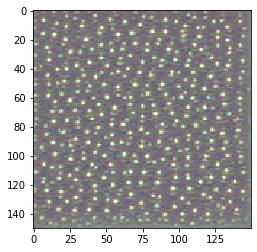

In [10]:
plt.imshow(generate_pattern('block3_conv1', 0))
plt.show()

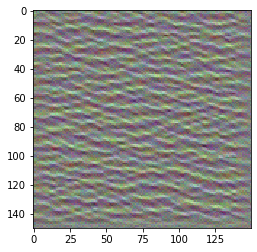

In [11]:
plt.imshow(generate_pattern('block3_conv1', 1))
plt.show()

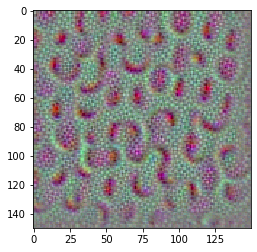

In [14]:
plt.imshow(generate_pattern('block4_conv1', 0))
plt.show()

In [12]:
# for layer_name in ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1']:
#     size = 64
#     margin = 5

#     # This a empty (black) image where we will store our results.
#     results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

#     for i in range(8):  # iterate over the rows of our results grid
#         for j in range(8):  # iterate over the columns of our results grid
#             # Generate the pattern for filter `i + (j * 8)` in `layer_name`
#             filter_img = generate_pattern(layer_name, i + (j * 8), size=size)

#             # Put the result in the square `(i, j)` of the results grid
#             horizontal_start = i * size + i * margin
#             horizontal_end = horizontal_start + size
#             vertical_start = j * size + j * margin
#             vertical_end = vertical_start + size
#             results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

#     # Display the results grid
#     plt.figure(figsize=(20, 20))
#     plt.imshow(results)
#     plt.show()